In [70]:
import os
import fiona
import pandas as pd
import json
import geopandas as gpd
from shapely.geometry import Polygon

# BRO Soil map dataset

--> This dataset is a multi-layered soil database that includes pedological properties and land characteristics.

## Load data

In [73]:
type_of_data = "soil_composition"

current_dir = os.getcwd()
datasetdir = os.path.join(current_dir, '../data/raw', type_of_data)
path = os.path.join(datasetdir, "BRO-SGM-DownloadBodemkaart-V2024-01_1.gpkg")

In [74]:
layers = fiona.listlayers(path)
layers

['areaofpedologicalinterest',
 'soilarea',
 'nga_properties',
 'soilmap',
 'normalsoilprofiles',
 'normalsoilprofiles_landuse',
 'soilhorizon',
 'soilhorizon_fractionparticlesize',
 'soillayer',
 'soil_units',
 'soilcharacteristics_bottomlayer',
 'soilcharacteristics_toplayer',
 'soilarea_normalsoilprofile',
 'soilarea_soilunit',
 'soilarea_soilunit_soilcharacteristicstoplayer',
 'soilarea_soilunit_soilcharacteristicsbottomlayer']

## Load needed layers

In [75]:
# NOTE: "normalsoilprofile" cannot be joined to any table as it does not have id number. Lower and Upper values are constant (0, 1.2) so we dont need this table at all. Work only with "soilhorizon"!

In [78]:
soilarea = gpd.read_file(path, layer="soilarea")  # table with geo
soilarea_normalsoilprofile = gpd.read_file(path, layer="soilarea_normalsoilprofile") # relationship between soilarea and horizon
horizon = gpd.read_file(path, layer="soilhorizon")   # table with soil characteristics
soilarea_soilunit  = gpd.read_file(path, layer="soilarea_soilunit")

/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: Unexpected data type for record 1 in column validfrom
  return ogr_read(


In [83]:
soilarea_soilunit

,maparea_id,soilunit_code,soilunit_sequencenumber
0,V2024-1..soilarea.0000007788,bEZ23,0
1,V2024-1..soilarea.0000007789,bEZ23,0
2,V2024-1..soilarea.0000007790,bEZ23,0
3,V2024-1..soilarea.0000007791,bEZ23,0
4,V2024-1..soilarea.0000007870,BLb6,0
...,...,...,...
49736,V2024-1..soilarea.0000047953,Zn21,0
49737,V2024-1..soilarea.0000047954,Zn21,0
49738,V2024-1..soilarea.0000047955,Zn21,0
49739,V2024-1..soilarea.0000047956,Zn21,0


## Merge data

In [86]:
area_geometry = soilarea[["maparea_id", "geometry"]]    # here we keep only necessary columns

# join 'soilhorizon' with 'soilarea_normalsoilprofile'
horizon_profiles_area = horizon.merge(soilarea_normalsoilprofile, on="normalsoilprofile_id")
horizon_with_geom = horizon_profiles_area.merge(area_geometry, on="maparea_id")
horizon_code_with_geom = horizon_with_geom.merge(soilarea_soilunit, on="maparea_id")

In [87]:
horizon_code_with_geom.isna().sum()

normalsoilprofile_id                0
layernumber                         0
faohorizonnotation                  0
lowervalue                          0
uppervalue                          0
staringseriesblock                  0
organicmattercontent                0
minimumorganicmattercontent         0
maximumorganicmattercontent         0
acidity                             0
minimumacidity                      0
maximumacidity                      0
cnratio                             0
peattype                       191416
calciccontent                       0
fedith                              0
loamcontent                         0
minimumloamcontent                  0
maximumloamcontent                  0
lutitecontent                       0
minimumlutitecontent                0
maximumlutitecontent                0
sandmedian                          0
minimumsandmedian                   0
maximumsandmedian                   0
siltcontent                         0
density     

--> In one polygon we have values for five levels of soil

In [88]:
horizon_code_with_geom = horizon_code_with_geom[["layernumber", "organicmattercontent", "lutitecontent", "soilunit_code", "geometry"]].copy()
horizon_code_with_geom

,layernumber,organicmattercontent,lutitecontent,soilunit_code,geometry
0,1,6.8,2,Hd30,"POLYGON ((226756 475715, 226757 475683, 226757..."
1,1,6.8,2,Hd30,"POLYGON ((232421 476085, 232441 476105, 232444..."
2,1,6.8,2,Hd30,"POLYGON ((231954 476332, 231936 476361, 231898..."
3,1,6.8,2,Hd30,"POLYGON ((232281 476788, 232330 476778, 232401..."
4,1,6.8,2,Hd30,"POLYGON ((228217 476637, 228184 476646, 228151..."
...,...,...,...,...,...
216153,4,3.0,65,Rv01C,"POLYGON ((127413.821 475025.001, 127398.475 47..."
216154,4,3.0,65,Rv01C,"POLYGON ((170875.765 441757.232, 170899.975 44..."
216155,4,3.0,65,Rv01C,"POLYGON ((129167.816 436603.082, 129187.925 43..."
216156,4,3.0,65,Rv01C,"POLYGON ((137509.228 438430.345, 137485.162 43..."


In [48]:
# NOTE: select 1st, 4th, 5th layer numbers! (most important in the key research paper)

## Crop the map

In [95]:
soil_geo = gpd.GeoDataFrame(horizon_code_with_geom, geometry="geometry")

In [96]:
def aoi_finder():
    # load Utrecht polygon coordinates
    utrecht_polygon_path = os.path.join(datasetdir, "..", "utrecht polygon.csv")
    df = pd.read_csv(utrecht_polygon_path, sep=';')

    geo_shape_str = df.loc[0, "Geo Shape"] #coordinates of the polygon
    geo_shape = json.loads(geo_shape_str)
    coords = geo_shape["coordinates"][0]  # outer ring of the polygon

    utrecht_polygon = Polygon(coords)

    # define boundary line
    x1, y1 = 5.066884, 52.170366  # upper-left
    x2, y2 = 5.237030, 51.978896  # lower-right

    def is_above_line(x, y):
        """Returns True if point (x, y) is above the diagonal line"""
        if x1 == x2:
            return y > y1  # vertical line
        slope = (y2 - y1) / (x2 - x1)
        y_on_line = slope * (x - x1) + y1
        return (y > y_on_line) and (x > x1)

    # Filter polygon coordinates
    filtered_coords = [
        (x, y) for x, y in utrecht_polygon.exterior.coords
        if is_above_line(x, y)]

    # Make sure polygon closes properly
    if filtered_coords[0] != filtered_coords[-1]:
        filtered_coords.append(filtered_coords[0])

    #new precise polygon
    aoi = Polygon(filtered_coords)

    utrecht_mask = gpd.GeoDataFrame(geometry=[aoi], crs="EPSG:4326")
    return utrecht_mask

In [97]:
utrecht_mask = aoi_finder()
utrecht_mask_rd = utrecht_mask.to_crs(soil_geo.crs)
cropped_gdf = gpd.overlay(soil_geo, utrecht_mask_rd, how='intersection')

## Organic matter content

--> Might seem that almost all Polygons have the same value but thats because many polygons have very low vaues (but they are different!). Try changing the threshold of values included in cropped_gdf["organicmattercontent"] <= 5

<Axes: >

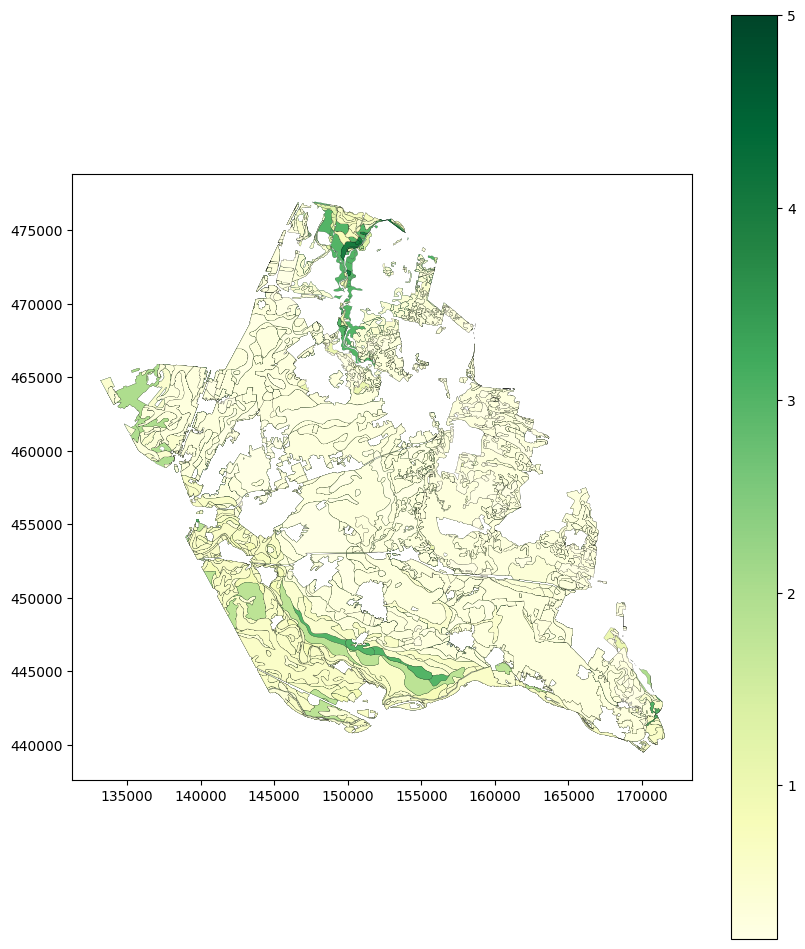

In [98]:
soil_geo_valid = cropped_gdf[cropped_gdf["organicmattercontent"].notna() &
                             (cropped_gdf["organicmattercontent"] <= 5)]

soil_geo_valid.plot(
    column="organicmattercontent",
    cmap="YlGn",
    legend=True,
    edgecolor="black",
    linewidth=0.1,
    figsize=(10, 12)
)

## Lutite content

<Axes: >

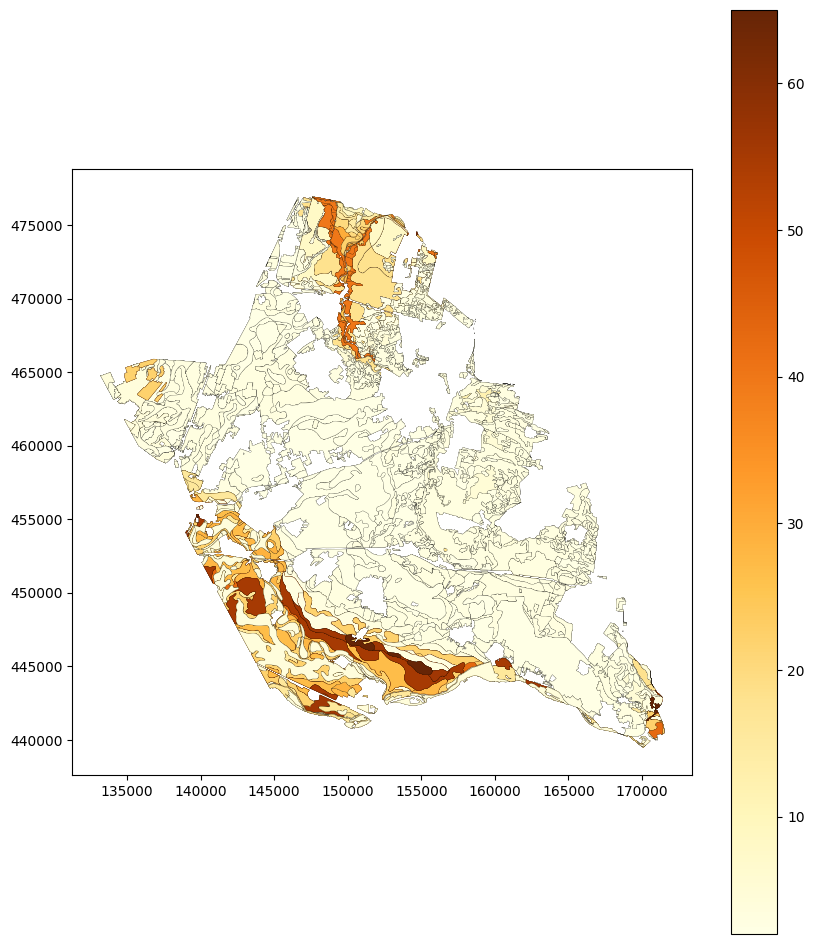

In [103]:
soil_geo_valid = cropped_gdf[cropped_gdf["lutitecontent"].notna()]

soil_geo_valid.plot(
    column="lutitecontent",
    cmap="YlOrBr",
    legend=True,
    edgecolor="black",
    linewidth=0.1,
    figsize=(10, 12)
)

## Soil Code

<Axes: >

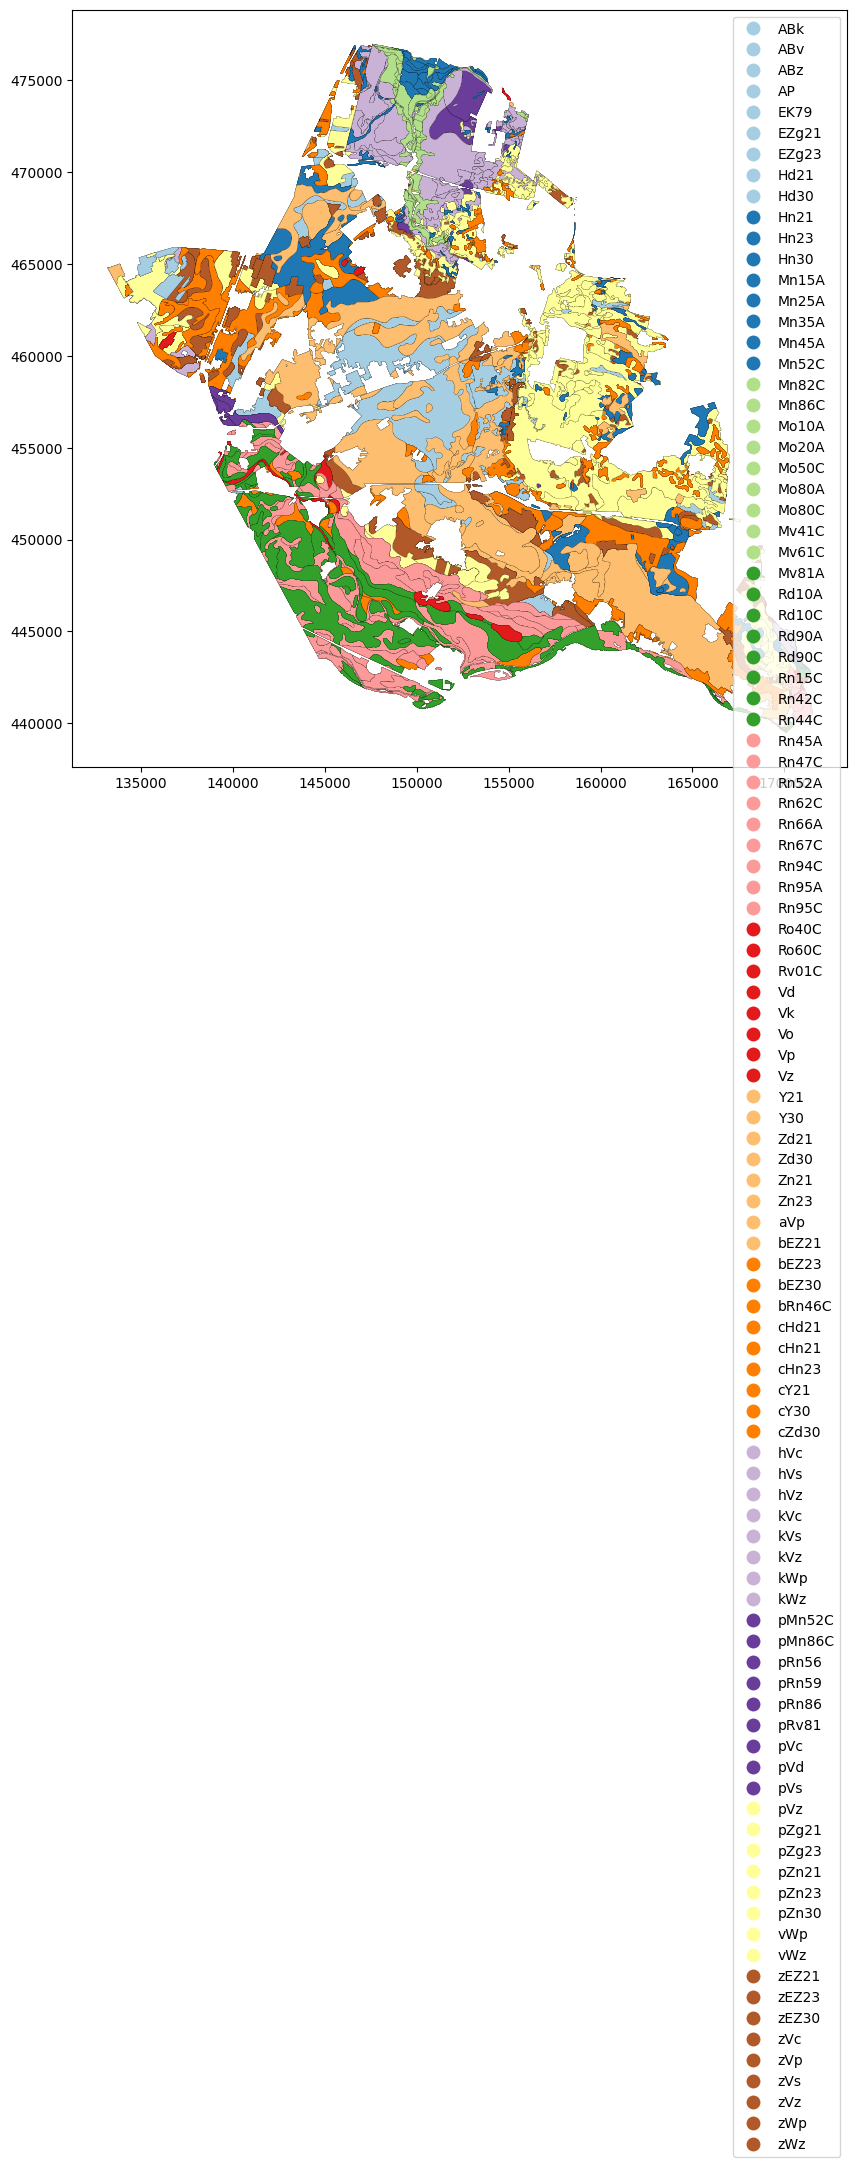

In [104]:
soil_geo_valid = cropped_gdf[cropped_gdf["soilunit_code"].notna()]

soil_geo_valid.plot(
    column="soilunit_code",
    cmap="Paired",
    legend=True,
    edgecolor="black",
    linewidth=0.1,
    figsize=(10, 12)
)